**Importing necessary libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import tensorflow, nltk, re, warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score

Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


**Reading the dataset**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Predicting Job Type by Job Description.csv', encoding='latin-1')
df.head(1)

,job_no,job_description,job_type,category
0,Id-12765,Zest Scientific is searching for an accomplis...,Permanent,"Pharmaceutical, Healthcare and Medical Sales"


**Checking for missing values**

In [ ]:
df.isnull().sum()

job_no             0
job_description    0
job_type           0
category           0
dtype: int64

**No missing values**

**Checking for and removing duplicates**

In [ ]:
print (df.shape)
df = df.drop_duplicates()
print (df.shape)

(17657, 4)
(17657, 4)


**No duplicates found**

**Selecting relevant columns**

In [ ]:
df = df.iloc[:,1:3]
df.head(1)

,job_description,job_type
0,Zest Scientific is searching for an accomplis...,Permanent


**Checking class distribution**

In [ ]:
df['job_type'].value_counts(normalize=True)

Permanent             0.893527
Contract/Interim      0.080082
Contract/Temp         0.017274
Temporary/Seasonal    0.006400
Any                   0.001416
Part-Time             0.001303
Name: job_type, dtype: float64

**The dataset is imbalanced.**

**Assigning numerical values to classes**

In [ ]:
df.replace ({"job_type": {'Permanent':0, 'Contract/Interim':1, "Contract/Temp": 2, "Temporary/Seasonal": 3,
                          "Any": 4, "Part-Time": 5}}, inplace = True)
df['job_type'].value_counts()

0    15777
1     1414
2      305
3      113
4       25
5       23
Name: job_type, dtype: int64

**Separating dependent and indpendent features**

In [ ]:
x = df.drop ('job_type', axis =1)
y = df['job_type']

**Storing a copy of independent variable in another variable for preprocessing tasks**

In [ ]:
content = x.copy()

**Initiating the lemmatizer**

In [ ]:
lem = WordNetLemmatizer()

**Lemmatization**

In [ ]:
corpus = []
for i in range(0, len(content)):
    description = re.sub('[^a-zA-Z]', ' ', content['job_description'][i])
    description = description.lower()
    description = description.split()
    description = [lem.lemmatize(word) for word in description if not word in stopwords.words('english')]
    description = ' '.join(description)
    corpus.append(description)

**Finding the number of unique words in dataframe (for selecting the vocabulary size) and the number of words in the sentence with the maximum length (for embedding purposes)**

In [ ]:
tokenized_corpus = [sentence.split() for sentence in corpus]

all_words = [word for sentence in tokenized_corpus for word in sentence]

vocabulary_size = len(set(all_words))

max_sentence_length = max(len(sentence) for sentence in tokenized_corpus)

print("Vocabulary Size:", vocabulary_size)
print("Maximum Sentence Length:", max_sentence_length)

Vocabulary Size: 41341
Maximum Sentence Length: 964


**One hot encoding of data and applying padding to ensure equal length**

In [ ]:
onehot_repr= [one_hot (words, vocabulary_size) for words in corpus]
embedded_docs = pad_sequences(onehot_repr, padding='post', maxlen = max_sentence_length)

**Converting preprocessed dependent feature to pandas dataframe**

In [ ]:
x_final_df = pd.DataFrame (embedded_docs)

**Concatenating the dependent and indpendent features**

In [ ]:
df_final = pd.concat ([x_final_df, y], axis = 1)
df_final.head(1)

,0,1,2,3,4,5,6,7,8,9,...,955,956,957,958,959,960,961,962,963,job_type
0,12717,1344,1885,27468,1344,3082,13229,25311,27823,34333,...,0,0,0,0,0,0,0,0,0,0


**Making train, test and validation splits**

In [ ]:
y_for_df_stratification = df_final['job_type']
train_old, test = train_test_split (df_final, test_size=0.2, random_state=10, stratify = y_for_df_stratification)

y_to_stratify_train = train_old['job_type']
train, val = train_test_split (train_old, test_size=0.2, random_state=10, stratify = y_to_stratify_train)

x_train = train.drop('job_type', axis =1)
y_train = train['job_type']

x_val = val.drop('job_type', axis =1)
y_val = val['job_type']

x_test = test.drop('job_type', axis =1)
y_test = test['job_type']

**Converting the data types of dependent and indpendent features back to numpy array**

In [ ]:
x_train = np.array (x_train)
x_val = np.array (x_val)
x_test = np.array (x_test)
y_train = np.array (y_train)
y_val = np.array (y_val)
y_test = np.array (y_test)

**Introducing early stopping to avoid overfitting**

In [ ]:
early_stopping = tensorflow.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.0001, patience=20,
                                                          verbose=1, mode="auto", baseline=None,
                                                          restore_best_weights=False, start_from_epoch=0)

**Assigning weights to different classes in order to account for the imbalanced data**

In [ ]:
weights_assigned = {0 : 1, 1 : 11.157708628005658, 2 : 51.72786885245902,
                    3 : 139.61946902654867, 4 : 631.08, 5 : 685.9565217391304}

**Defining model parameters and creating a bidirectional LSTM RNN model**

In [ ]:
embedding_vector_features = 40
model=Sequential()
model.add(Embedding(vocabulary_size, embedding_vector_features, input_length = max_sentence_length))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(200)))
model.add(Dropout(0.3))
model.add(Dense(units = 6, activation='softmax'))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 964, 40)           1653640   
                                                                 
 dropout (Dropout)           (None, 964, 40)           0         
                                                                 
 bidirectional (Bidirection  (None, 400)               385600    
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 400)               0         
                                                                 
 dense (Dense)               (None, 6)                 2406      
                                                                 
Total params: 2041646 (7.79 MB)
Trainable params: 2041646 (7.79 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

**Model training**

In [ ]:
model_history = model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs=1000, batch_size=100,
                          callbacks=early_stopping, class_weight = weights_assigned)

Epoch 1/1000
113/113 [==============================] - 50s 326ms/step - loss: 10.0335 - accuracy: 0.1369 - val_loss: 1.8386 - val_accuracy: 0.0050
Epoch 2/1000
113/113 [==============================] - 35s 310ms/step - loss: 9.7479 - accuracy: 0.1087 - val_loss: 1.8274 - val_accuracy: 0.0573
Epoch 3/1000
113/113 [==============================] - 31s 277ms/step - loss: 8.9441 - accuracy: 0.2981 - val_loss: 1.6985 - val_accuracy: 0.2457
Epoch 4/1000
113/113 [==============================] - 33s 289ms/step - loss: 7.7476 - accuracy: 0.5119 - val_loss: 1.4964 - val_accuracy: 0.7384
Epoch 5/1000
113/113 [==============================] - 30s 264ms/step - loss: 6.2397 - accuracy: 0.7397 - val_loss: 1.2199 - val_accuracy: 0.7600
Epoch 6/1000
113/113 [==============================] - 31s 277ms/step - loss: 4.3282 - accuracy: 0.7495 - val_loss: 0.8888 - val_accuracy: 0.7908
Epoch 7/1000
113/113 [==============================] - 29s 259ms/step - loss: 2.4504 - accuracy: 0.8000 - val_loss: 

**Plotting model's accuracy during training**

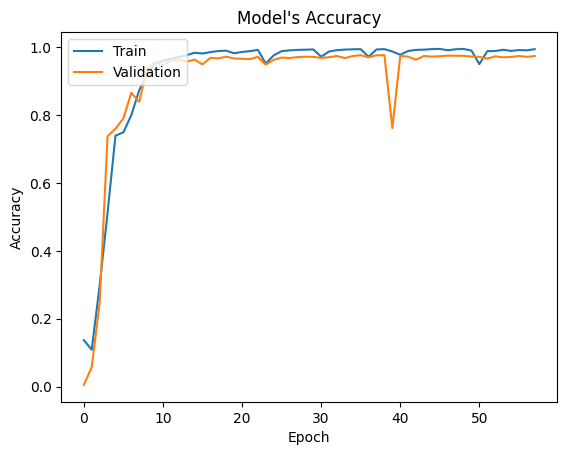

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title("Model's Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Plotting model's loss during training**

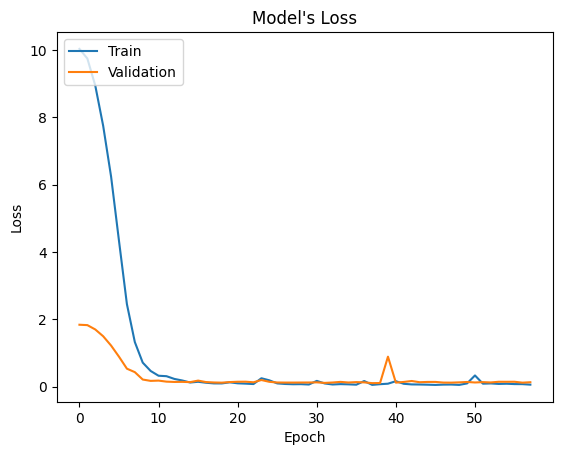

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title("Model's Loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**Model evaluation**

In [ ]:
y_pred_train = model.predict(x_train)
y_pred_train = np.argmax(y_pred_train, axis=1)

y_pred_test = model.predict(x_test)
y_pred_test = np.argmax(y_pred_test, axis=1)

print ('Accuracy on training set:', accuracy_score (y_pred_train, y_train)*100)
print ('Accuracy on test set:', accuracy_score (y_pred_test, y_test)*100)

print ("Correct predictions on training data:", sum (y_train == y_pred_train))
print ("Correct predictions on test data:", sum (y_test == y_pred_test))

print ("Incorrect predictions on training data:", sum (y_train != y_pred_train))
print ("Incorrect predictions on test data:", sum (y_test != y_pred_test))

print ("F1 score on training data:", f1_score(y_train, y_pred_train, average='weighted'))
print ("F1 score on test data:", f1_score(y_test, y_pred_test, average='weighted'))

print ('Precision on training data: %.3f' % precision_score(y_train, y_pred_train, average='weighted'))
print ('Precision on test data: %.3f' % precision_score(y_test, y_pred_test, average='weighted'))

print ('Recall on training data: %.3f' % recall_score(y_train, y_pred_train, average='weighted'))
print ('Recall on test data: %.3f' % recall_score(y_test, y_pred_test, average='weighted'))

print ('Confusion matrix of training set:\n', confusion_matrix (y_train, y_pred_train))
print ('Confusion matrix of test set:\n', confusion_matrix (y_test, y_pred_test))

print ("Classification report of training data:\n", classification_report (y_train, y_pred_train, digits = 4))
print ("Classification report of test data:\n", classification_report (y_test, y_pred_test, digits = 4))

111/111 [==============================] - 4s 32ms/step
Accuracy on training set: 99.54867256637168
Accuracy on test set: 98.24462061155153
Correct predictions on training data: 11249
Correct predictions on test data: 3470
Incorrect predictions on training data: 51
Incorrect predictions on test data: 62
F1 score on training data: 0.995704547297116
F1 score on test data: 0.9827047573442619
Precision on training data: 0.996
Precision on test data: 0.983
Recall on training data: 0.995
Recall on test data: 0.982
Confusion matrix of training set:
 [[10047    20     0    27     0     3]
 [    0   905     0     0     0     0]
 [    0     0   194     1     0     0]
 [    0     0     0    72     0     0]
 [    0     0     0     0    16     0]
 [    0     0     0     0     0    15]]
Confusion matrix of test set:
 [[3120   23    6    6    1    0]
 [  16  262    3    2    0    0]
 [   3    0   58    0    0    0]
 [   2    0    0   21    0    0]
 [   0    0    0    0    5    0]
 [   0    0    0    

**Taking custom user input and making predictions from the trained model**

In [ ]:
prediction = input("Enter the text you want to predict: ")
corpus_prediction = []
description_prediction = re.sub('[^a-zA-Z]', ' ', prediction)
description_prediction = description_prediction.lower()
description_prediction = description_prediction.split()
description_prediction = [lem.lemmatize(word) for word in description_prediction if not word in stopwords.words('english')]
description_prediction = ' '.join(description_prediction)
corpus_prediction.append(description_prediction)
onehot_repr_prediction = [one_hot(words, vocabulary_size) for words in corpus_prediction]
embedded_docs_prediction = pad_sequences(onehot_repr_prediction, padding='post', maxlen=max_sentence_length)
x_prediction = np.array(embedded_docs_prediction)
y_pred_prediction = model.predict(x_prediction)
y_pred_prediction = np.argmax(y_pred_prediction, axis=1)

if y_pred_prediction == 0:
  print("Prediction: It's a permanent job.")
elif y_pred_prediction == 1:
  print("Prediction: It's an interim job.")
elif y_pred_prediction == 2:
  print("Prediction: It's a temporary job.")
elif y_pred_prediction == 3:
  print("Prediction: It's a seasonal job.")
elif y_pred_prediction == 4:
  print("Prediction: It can be any job.")
elif y_pred_prediction == 5:
  print("Prediction: It's a part-time job.")

Enter the text you want to predict: We are currently recruiting for a market leading Pharmacy chain with an exciting new opportunity working as a Pharmacist Manager working in Abingdon. Our client are a forward thinking company with a heavy emphasis on training and support, as well as customer service.   Essential Requirements:    You will be a highly experienced Pharmacist with current valid GPHC registration and MUR accreditation.   You will have ProScript experience.   Ability to build good relationships with both customers and staff.   Possess exceptional leadership qualities.   Ability to lead and motivate a team.   Outstanding attention to detail.   Role Responsibilities:   Managing a team, you will inspire and develop colleagues.   Ensuring all key targets are met and that excellent standards are consistently delivered will be crucial to your success.   You will build working relationships with Primary Care Organisations (PCOs) and GP surgeries    You will ensure payment claims 